# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [1]:
#!rm *.pkl
#!wget https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/data/mnist.pkl.gz
#!gzip -d mnist.pkl.gz

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

import pickle
import gzip

with gzip.open('../mnist.pkl.gz', 'rb') as file_contents:
    MNIST = pickle.load(file_contents, encoding='latin1');

In [2]:
labels = MNIST[0][1]
data = MNIST[0][0]

Let's see what is the shape of data that we have:

In [3]:
data.shape

(50000, 784)

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [15]:
# from sklearn.model_selection import train_test_split
# features_train, features_test, labels_train, labels_test = train_test_split(data,labels,test_size=0.2)
# print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

# Get training data from MNIST dataset
features_train = data
labels_train = labels

# Get test data from MNIST dataset
features_test = MNIST[1][0]
labels_test = MNIST[1][1]

# Print info about each
print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")
print(f"Train labels: {len(labels_train)}, test labels: {len(labels_test)}")

Train samples: 50000, test samples: 10000
Train labels: 50000, test labels: 10000


### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

In [78]:
# 1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module

class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db
        
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p
    
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
                
def train_epoch(net, features_train, labels_train, loss=CrossEntropyLoss(), batch_size=40, lr=0.1):
    for i in range(0,len(features_train),batch_size):
        xb = features_train[i:i+batch_size]
        yb = labels_train[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
        
def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

def train_and_plot(n_epoch, net, loss, batch_size=40, lr=0.1):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim(0, n_epoch + 1)
    ax.set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN
    
    tloss, taccuracy = get_loss_acc(features_train,labels_train,loss)
    vloss, vaccuracy = get_loss_acc(features_test,labels_test,loss)
    
    for epoch in range(1, n_epoch + 1):
        
        train_epoch(net,features_train,labels_train,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(features_train,labels_train,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(features_test,labels_test,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax.set_ylim(0.8, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],valid_acc[:, 2]), fig, ax)
        
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.set_xlabel("Epoch Number")
    ax.set_ylabel("Accuracy")
    ax.legend(ax.lines, ['training', 'validation'],
              loc='upper center', ncol = 2)

<IPython.core.display.Javascript object>


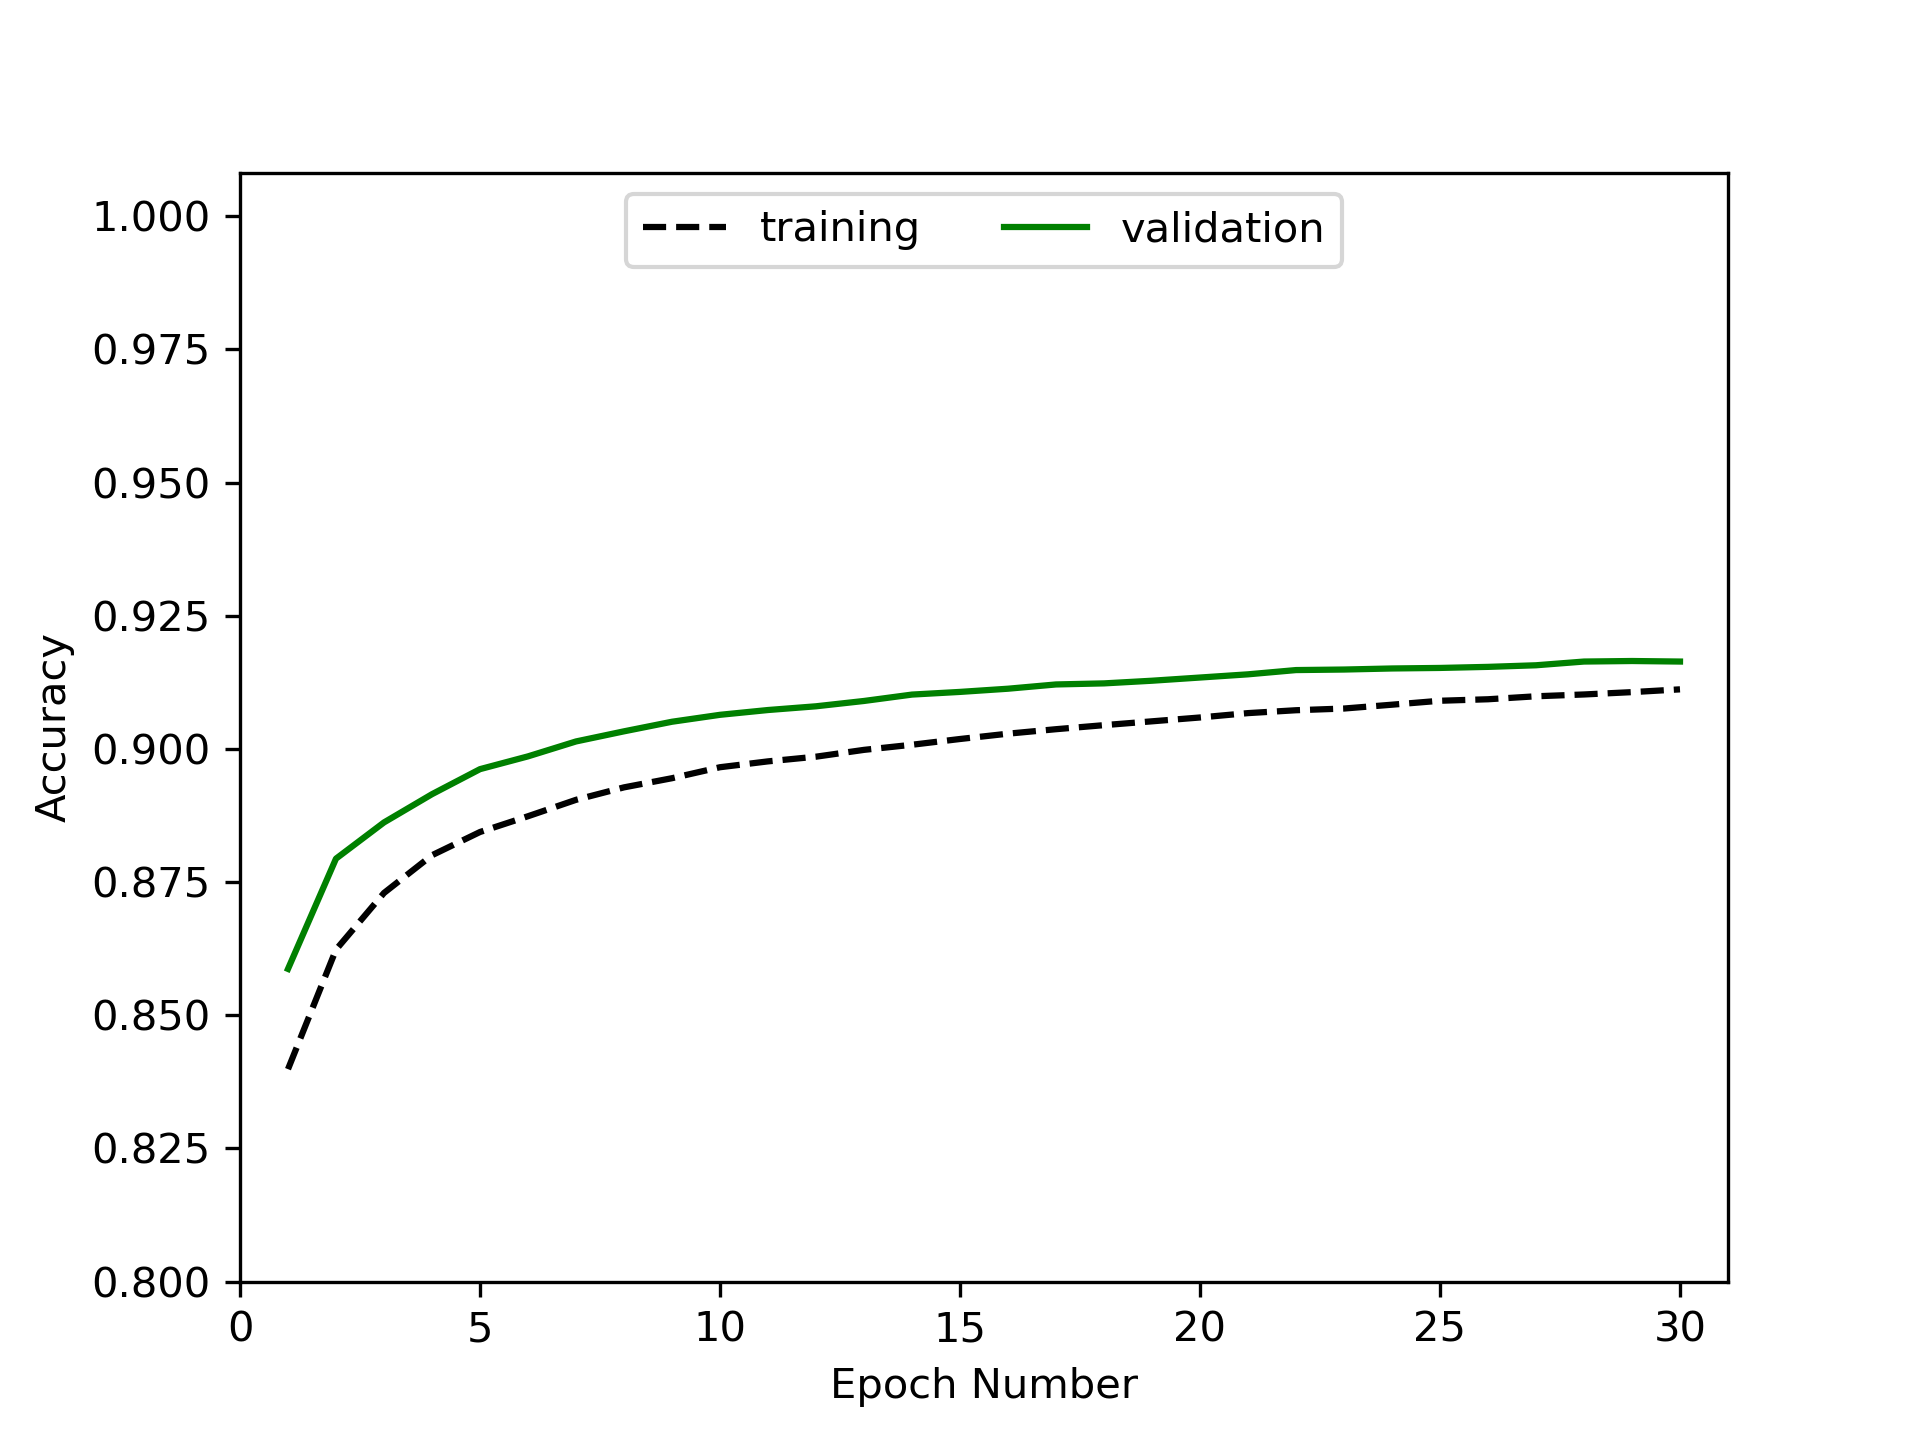

In [64]:
# 2. Define and train one-layered perceptron, observing training and validation accuracy during training

%matplotlib nbagg 
net = Net()
net.add(Linear(784,10))
net.add(Softmax())
loss = CrossEntropyLoss()

res = train_and_plot(30,net,loss,lr=0.005)

In [66]:
# 4. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy
    
class Sigmoid:
    def forward(self,x):
        y = 1/(1 + np.exp(-x))
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

<IPython.core.display.Javascript object>


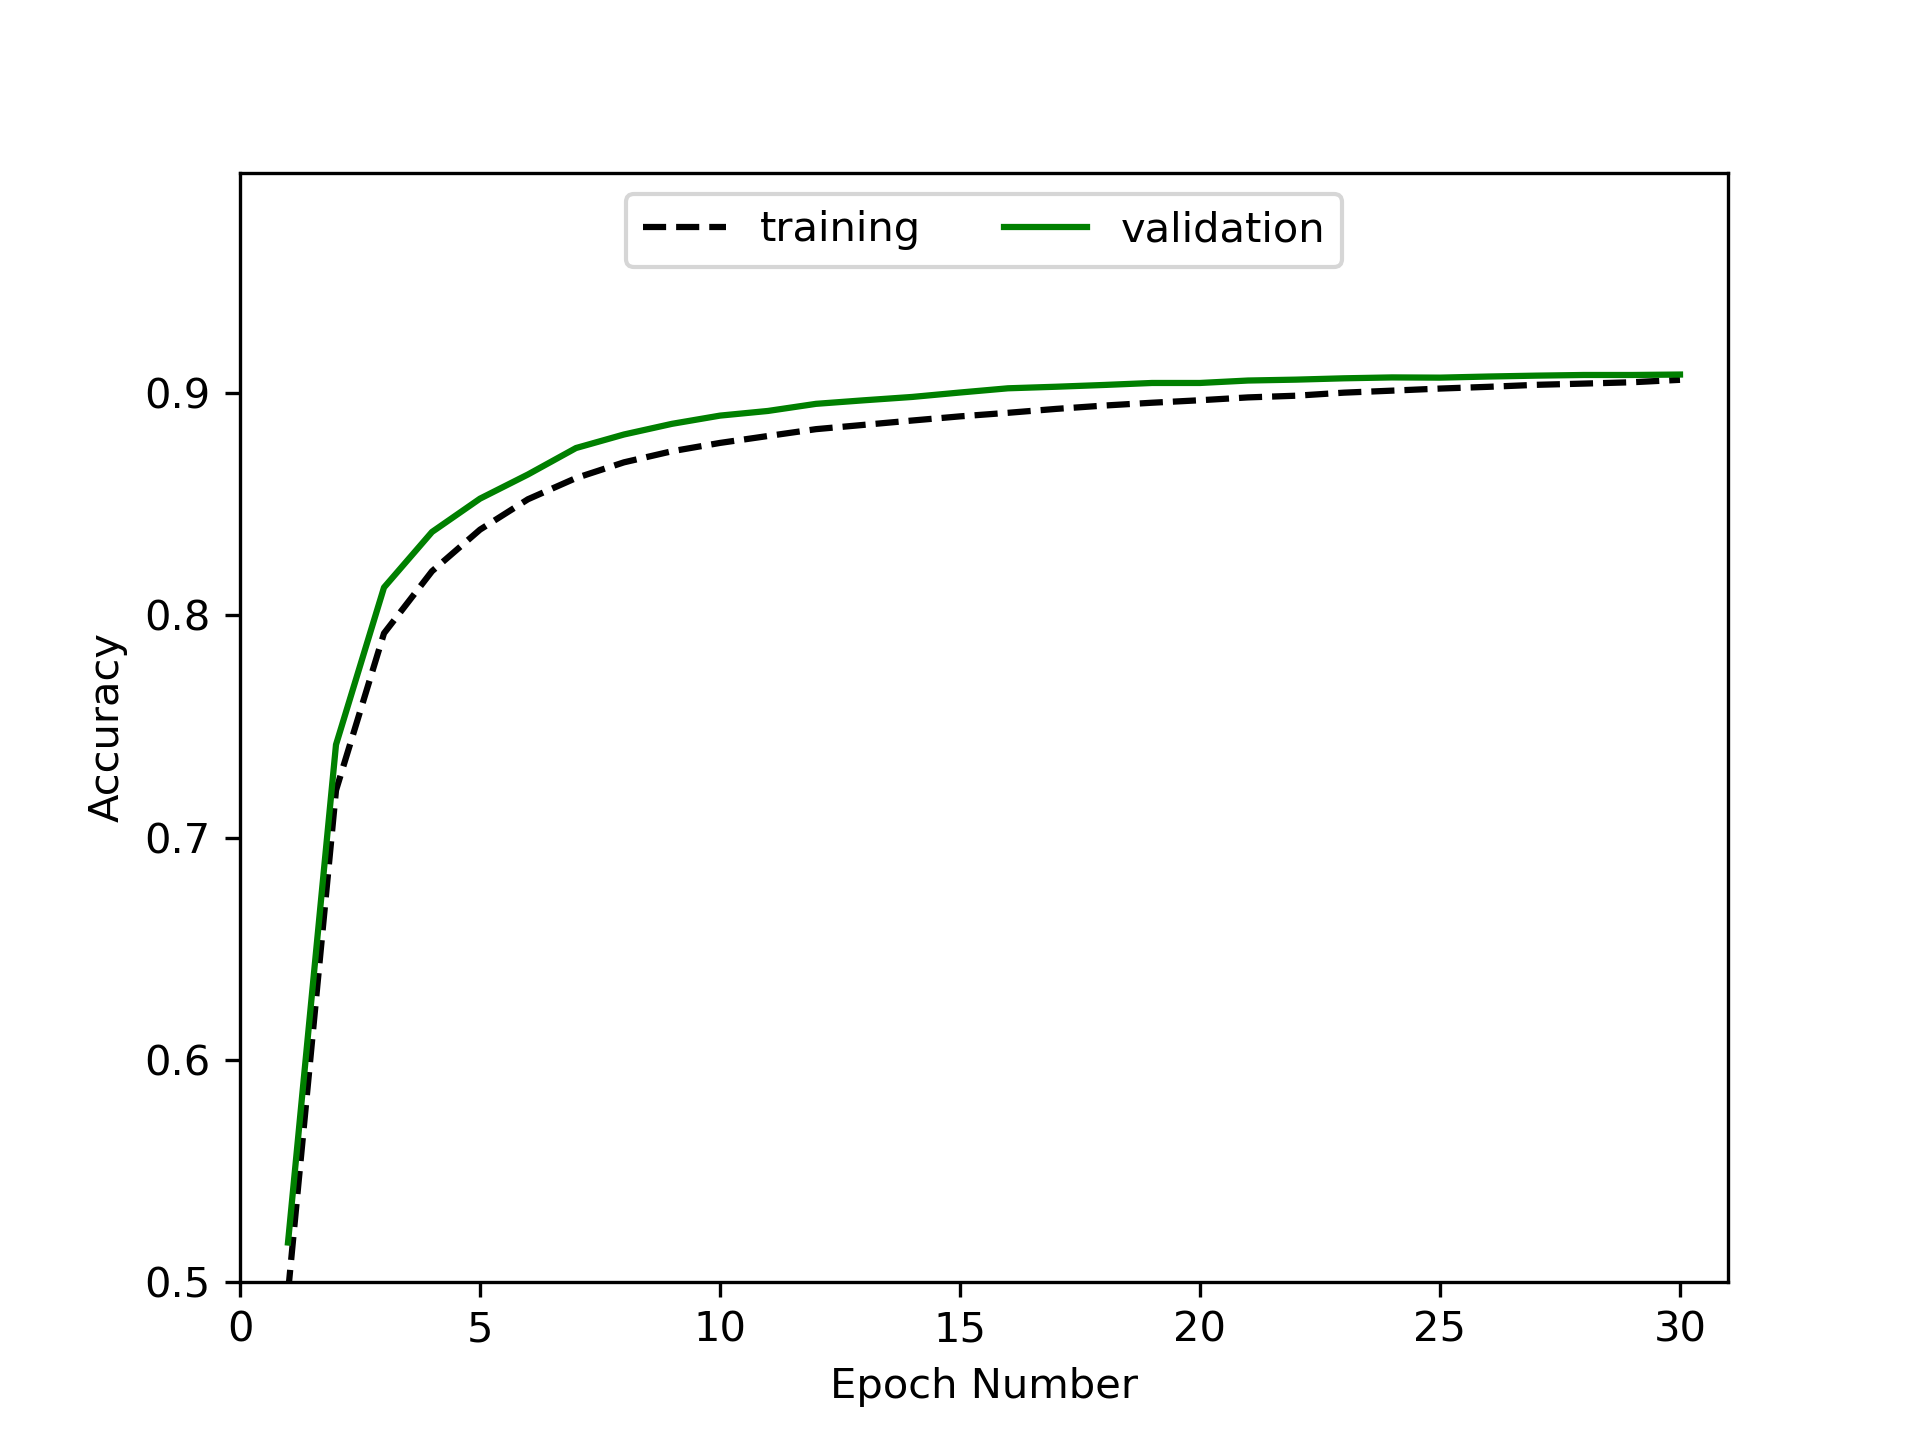

In [70]:
# 2-layered perceptron

# activation function is Tanh()
net = Net()
net.add(Linear(784,10))
net.add(Tanh())
net.add(Linear(10,784))
net.add(Softmax())
loss = CrossEntropyLoss()

res = train_and_plot(30,net,loss,lr=0.005)

<IPython.core.display.Javascript object>


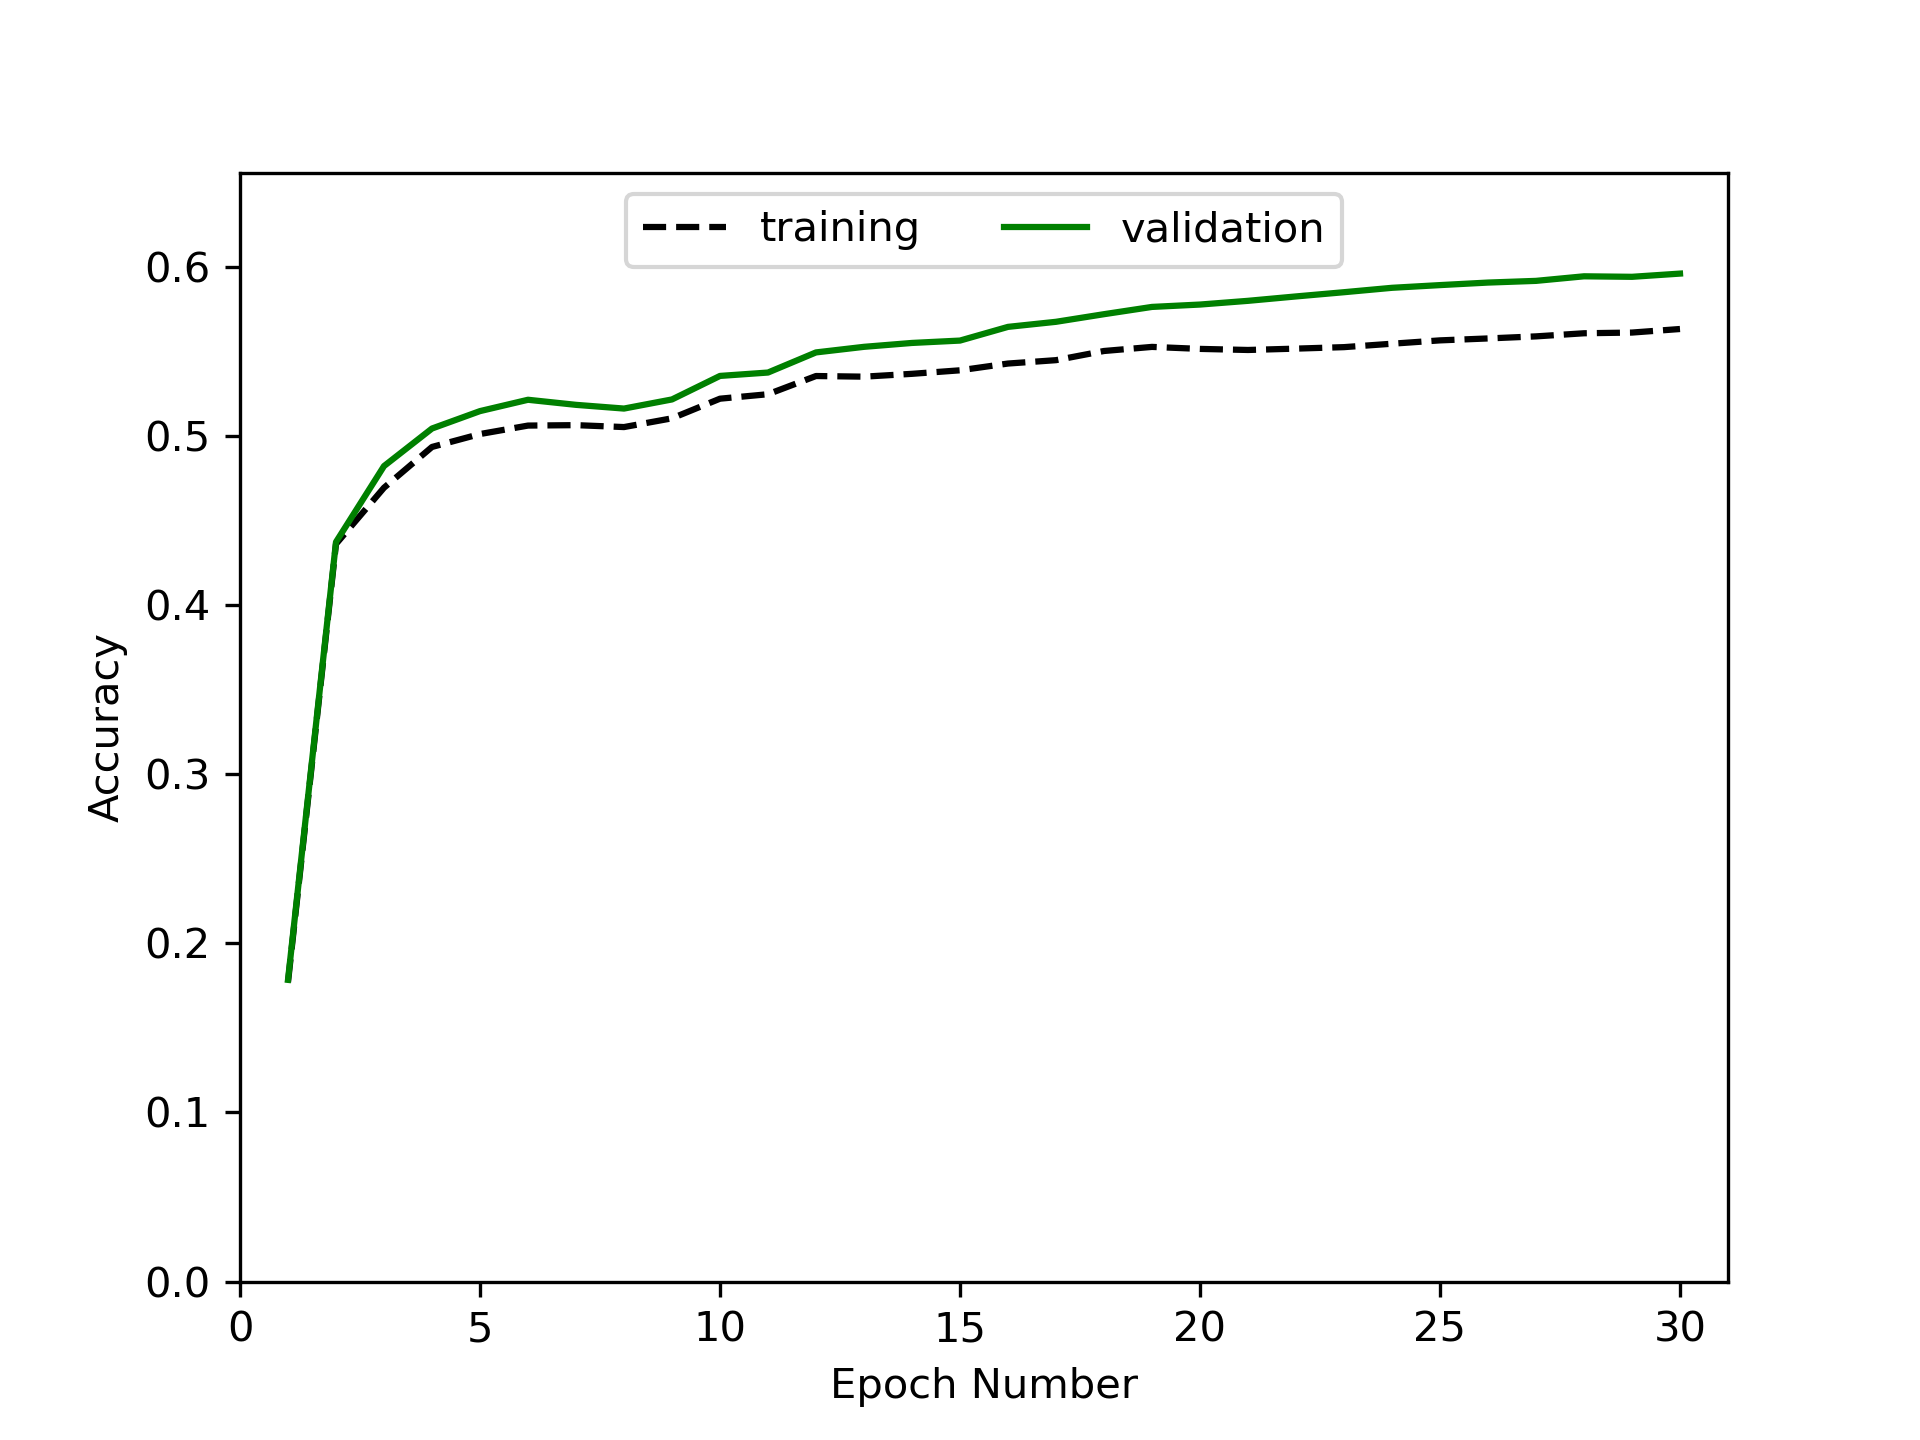

C:\Users\rachs\AppData\Local\Temp/ipykernel_6680/78079983.py:13: RuntimeWarning: overflow encountered in exp
  y = 1/(1 + np.exp(-x))
C:\Users\rachs\AppData\Local\Temp/ipykernel_6680/78079983.py:13: RuntimeWarning: overflow encountered in exp
  y = 1/(1 + np.exp(-x))
C:\Users\rachs\AppData\Local\Temp/ipykernel_6680/78079983.py:13: RuntimeWarning: overflow encountered in exp
  y = 1/(1 + np.exp(-x))
C:\Users\rachs\AppData\Local\Temp/ipykernel_6680/78079983.py:13: RuntimeWarning: overflow encountered in exp
  y = 1/(1 + np.exp(-x))


In [75]:
# 2-layered perceptron

# activation function is Sigmoid()
net = Net()
net.add(Linear(784,10))
net.add(Sigmoid())
net.add(Linear(10,784))
net.add(Softmax())
loss = CrossEntropyLoss()

res = train_and_plot(30,net,loss,lr=0.005)

<IPython.core.display.Javascript object>


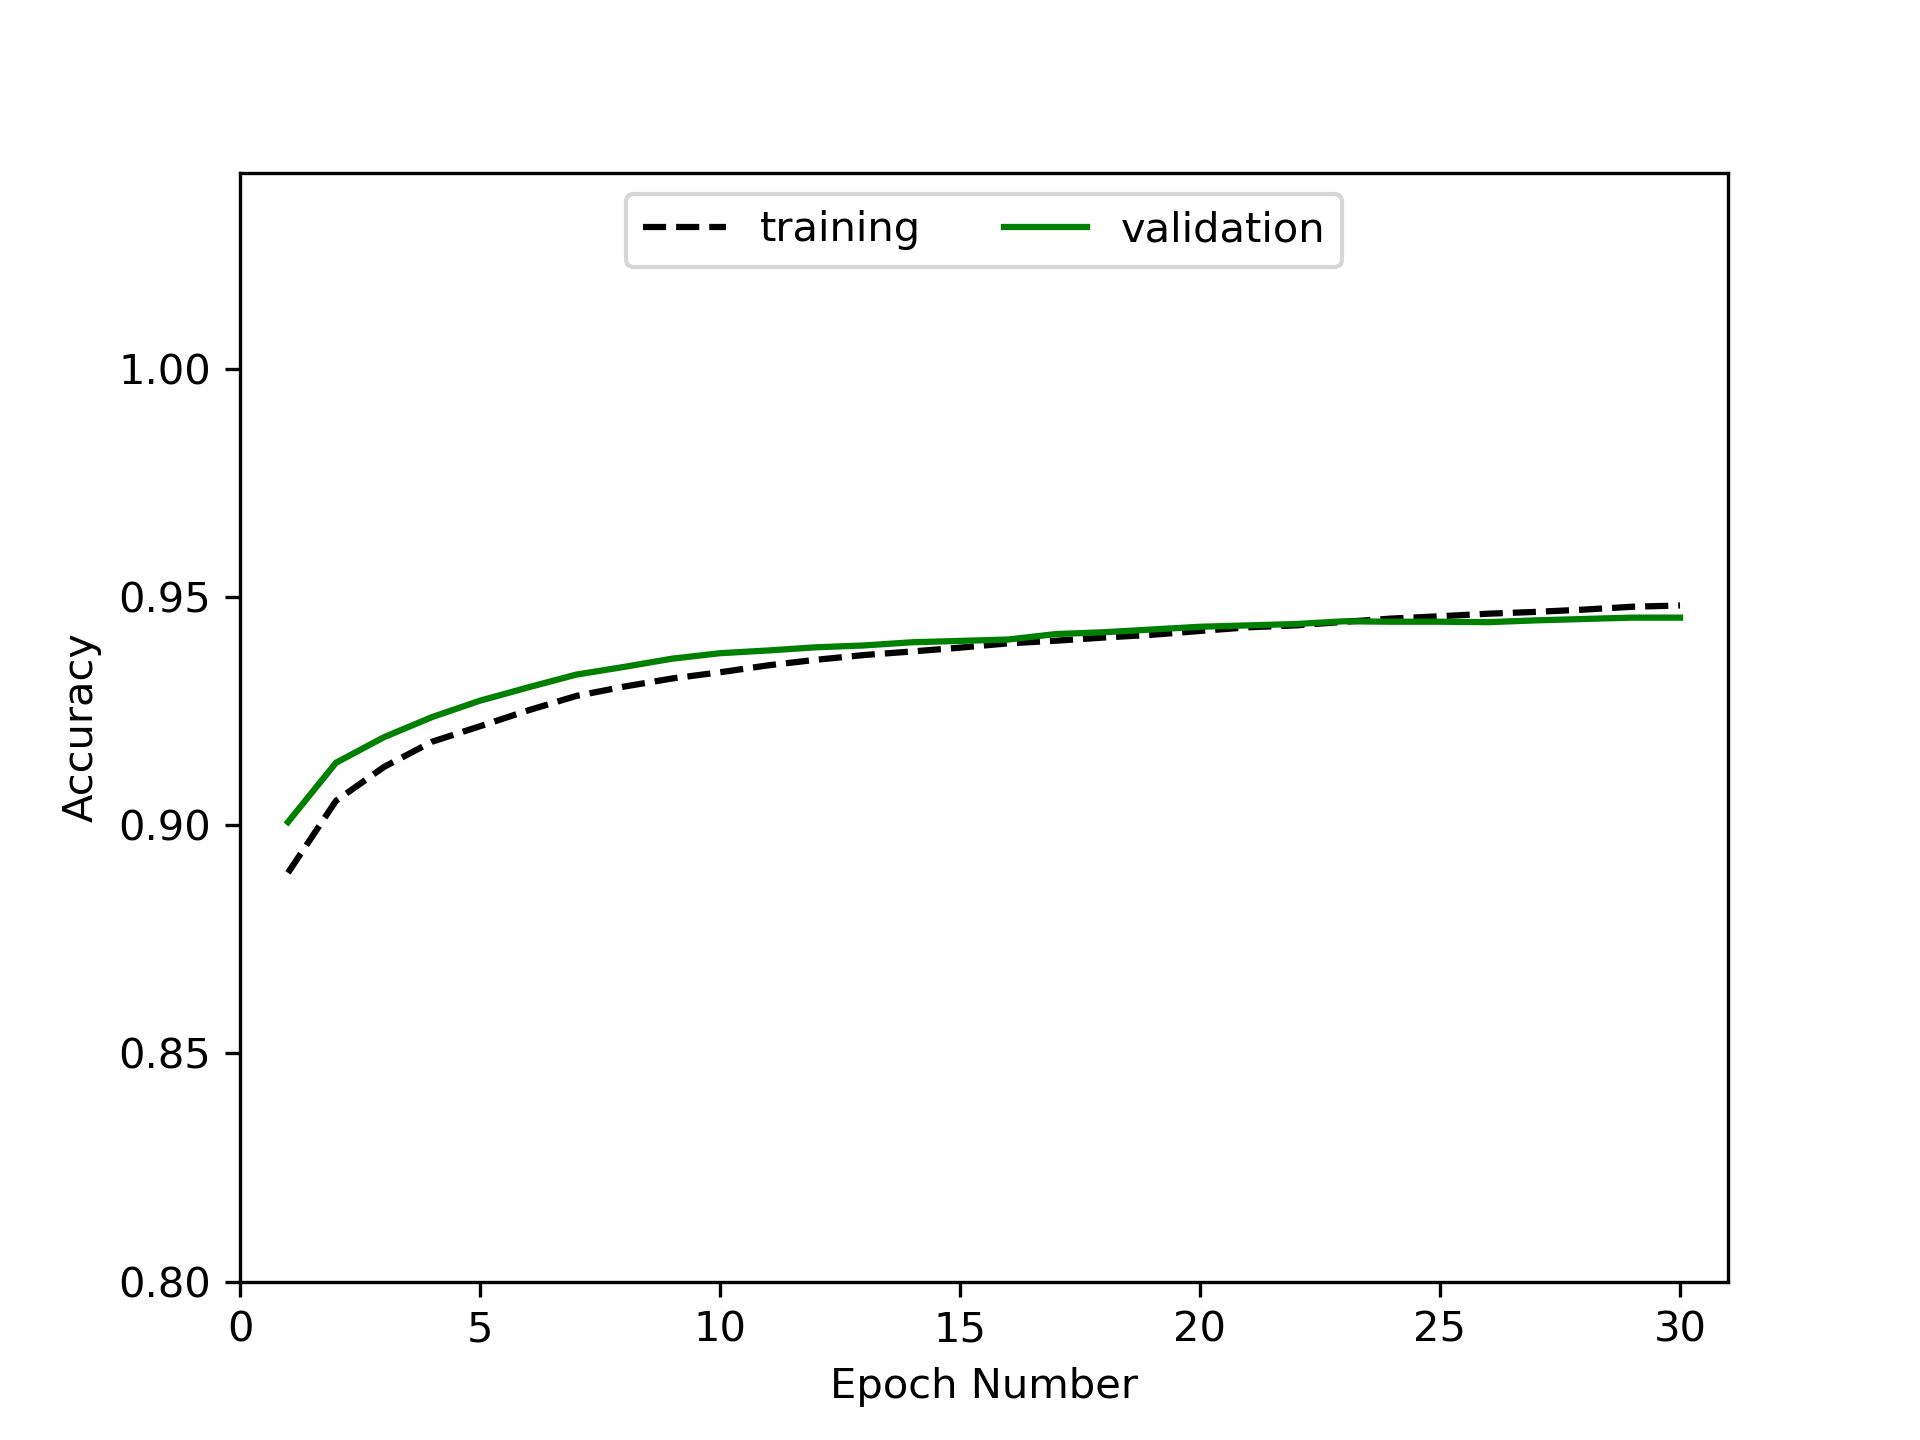

In [80]:
# 3-layered perceptron
%matplotlib nbagg
net = Net()
net.add(Linear(784,10))
net.add(Tanh())
net.add(Linear(10,784))
net.add(Tanh())
net.add(Linear(784,10))
net.add(Softmax())
loss = CrossEntropyLoss()

res = train_and_plot(30,net,loss,lr=0.005)